# Final Project Report

* Class: DS 5100
* Student Name: Greg Miller
* Student Net ID: aem2cz
* This URL: https://github.com/millergl89/MonteCarlo_Simulator/blob/main/DS51200_FinalProjectTemplate.ipynb

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/millergl89/MonteCarlo_Simulator

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

In [ ]:
```
import numpy as np
import pandas as pd

class Die:
    """
    A die has N sides, or “faces”, and W weights, and can be rolled to select a face.

    Each face contains a unique symbol (either all strings or all numbers). Weights default to 1.0 but can be changed.

    Attributes
        __df : pandas.DataFrame
            A private dataframe indexed by face, with a column for the weight.

    Methods
        change_weight(face, new_weight):
            Change the weight of a single face after initialization.
        
        roll(times=1):
            Roll the die one or more times.

        show():
            Return a copy of the die’s current state.
    """

    def __init__(self, faces):
        """
        Initialize the Die with a NumPy array of unique faces.

        Parameters
            faces : numpy.ndarray
                Array of face symbols (must be unique and of a consistent type).
        """
        if not isinstance(faces, np.ndarray):
            raise TypeError("Faces must be a NumPy array.")
        if len(np.unique(faces)) != len(faces):
            raise ValueError("All face values must be unique.")

        self.__df = pd.DataFrame({
            'weight': np.ones(len(faces), dtype=float)
        }, index=faces)

    def change_weight(self, face, new_weight):
        """
        Change the weight of a single face.

        Parameters
            face : object
                The face value whose weight is to be changed.
            new_weight : float or int
                The new weight to assign. Must be numeric.
        """
        if face not in self.__df.index:
            raise IndexError("Not a valid face.")
        try:
            new_weight = float(new_weight)
        except (ValueError, TypeError):
            raise TypeError("Weight must be numeric.")
        self.__df.loc[face, 'weight'] = new_weight

    def roll(self, times=1):
        """
        Roll the die one or more times.

        Parameters
            times : int, optional
                The number of times to roll the die. Default is 1.

        Returns
            list
                List of outcomes from rolling the die.
        """
        faces = self.__df.index.to_numpy()
        weights = self.__df['weight'].to_numpy()
        rolls = np.random.choice(faces, size=times, replace=True, p=weights / weights.sum())
        return rolls.tolist()

    def show(self):
        """
        Show the current state of the die.

        Returns
            pandas.DataFrame
                A copy of the internal dataframe showing faces and weights.
        """
        return self.__df.copy()


class Game:
    """
    A game consists of rolling one or more similar Die objects one or more times.

    Dice in a game must have the same faces, but may have different weights.

    Attributes
        dice_list : list
            List of Die objects used in the game.
        _play_df : pandas.DataFrame or None
            Private dataframe storing the most recent game play results.

    Methods
        play(num_rolls):
            Roll all dice a given number of times and store the result.
        show(form='wide'):
            Show the results of the most recent play in wide or narrow format.
    """

    def __init__(self, dice_list):
        self.dice = dice_list
        self._play_df = None

    def play(self, num_rolls):
        """
        Roll all dice a specified number of times.

        Parameters
            num_rolls : int
                Number of times to roll each die.

        Updates
            self._play_df : pandas.DataFrame
                Stores results of the play in wide format.
        """
        results = {}
        for i, die in enumerate(self.dice):
            rolls = die.roll(num_rolls)
            results[i] = rolls

        self._play_df = pd.DataFrame(results)
        self._play_df.index.name = 'Roll'

    def show(self, form='wide'):
        """
        Show the result of the most recent play.

        Parameters
            form : str, optional
                'wide' (default) returns wide format with roll numbers as index.
                'narrow' returns a MultiIndex with roll and die number.

        Returns
            pandas.DataFrame
                Copy of the results dataframe in the specified format.
        """
        if self._play_df is None:
            raise ValueError("No game has been played yet.")

        if form == 'wide':
            return self._play_df.copy()

        elif form == 'narrow':
            narrow_df = self._play_df.stack()
            narrow_df.index.set_names(['Roll', 'Die'], inplace=True)
            narrow_df.name = 'Outcome'
            return narrow_df.to_frame()

        else:
            raise ValueError("Invalid form. Use 'wide' or 'narrow'.")


class Analyzer:
    """
    Analyzer class to compute descriptive statistical properties of a Game object.

    Attributes
        game : Game
            The Game object to analyze.
            
        results : pandas.DataFrame
            A copy of the game's most recent play results in wide format.

    Methods
        jackpot():
            Count how many times all dice had the same face value.

        face_counts_per_roll():
            Count the number of times each face appeared per roll.

        combo_count():
            Count occurrences of unique combinations of face values (order-independent).

        permutation_count():
            Count occurrences of unique permutations of face values (order-dependent).
    """

    def __init__(self, game):
        """
        Initialize the Analyzer with a Game object.

        Parameters
            game : Game
                The Game object to analyze.
        """
        if not isinstance(game, Game):
            raise ValueError("Input must be a Game object.")

        self.game = game
        self.results = self.game.show(form='wide').copy()

    def jackpot(self):
        """
        Count how many times the roll resulted in all dice showing the same face.

        Returns
            int
                Number of jackpot outcomes (all dice in a roll show the same face).
        """
        return int((self.results.nunique(axis=1) == 1).sum())

    def face_counts_per_roll(self):
        """
        Count the number of times each face appeared in each roll.

        Returns
            counts - pandas.DataFrame
                A dataframe with roll numbers as index and face counts as columns.
                Missing face counts are filled with 0.
        """
        counts = self.results.apply(lambda row: row.value_counts(), axis=1)
        return counts.fillna(0).astype(int)

    def combo_count(self):
        """
        Count unique combinations of rolled faces (order-independent).

        Returns
            combo_counts - pandas.DataFrame
                A dataframe with MultiIndex of combinations and counts.
        """
        combos = self.results.apply(lambda row: tuple(sorted(row)), axis=1)
        combo_counts = combos.value_counts().to_frame(name='Count')
        combo_counts.index.name = 'Combination'
        return combo_counts

    def permutation_count(self):
        """
        Count unique permutations of rolled faces (order-dependent).

        Returns
            perm_counts - pandas.DataFrame
                A dataframe with MultiIndex of permutations and counts.
        """
        perms = self.results.apply(lambda row: tuple(row), axis=1)
        perm_counts = perms.value_counts().to_frame(name='Count')
        perm_counts.index.name = 'Permutation'
        return perm_counts
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

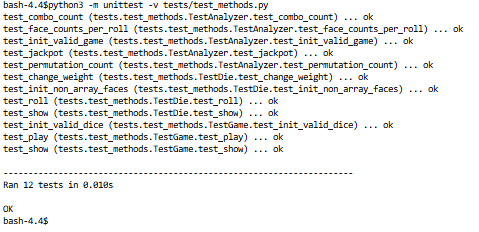

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [1]:
from montecarlo.MonteCarlo import Die, Game, Analyzer

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [8]:
help(montecarlo.MonteCarlo)

Help on module montecarlo.MonteCarlo in montecarlo:

NAME
    montecarlo.MonteCarlo

CLASSES
    builtins.object
        Analyzer
        Die
        Game
    
    class Analyzer(builtins.object)
     |  Analyzer class to compute descriptive statistical properties of a Game object.
     |  
     |  Attributes
     |      game : Game
     |          The Game object to analyze.
     |          
     |      results : pandas.DataFrame
     |          A copy of the game's most recent play results in wide format.
     |  
     |  Methods
     |      jackpot():
     |          Count how many times all dice had the same face value.
     |  
     |      face_counts_per_roll():
     |          Count the number of times each face appeared per roll.
     |  
     |      combo_count():
     |          Count occurrences of unique combinations of face values (order-independent).
     |  
     |      permutation_count():
     |          Count occurrences of unique permutations of face values (order-de

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL:https://github.com/millergl89/MonteCarlo_Simulator/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

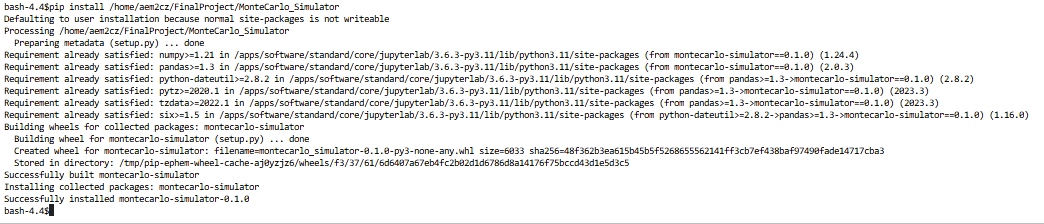

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [14]:
import numpy as np
fair_coin = Die(np.array(["H", "T"]))

unfair_coin = Die(np.array(["H", "T"]))
unfair_coin.change_weight("H", 5)


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [21]:
fair_game = Game([fair_coin, fair_coin])
fair_game.play(num_rolls =1000)

Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [20]:
unfair_game = Game([unfair_coin, unfair_coin, fair_coin])
unfair_game.play(num_rolls =1000)

Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [26]:
analyzer_fair = Analyzer(fair_game)
analyzer_unfair = Analyzer(unfair_game)

print(analyzer_fair.jackpot())
print(analyzer_unfair.jackpot())

510
374


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [31]:
freq_fair = analyzer_fair.jackpot()/1000
freq_unfair = analyzer_unfair.jackpot()/1000

print(freq_fair)
print(freq_unfair)

0.51
0.374


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

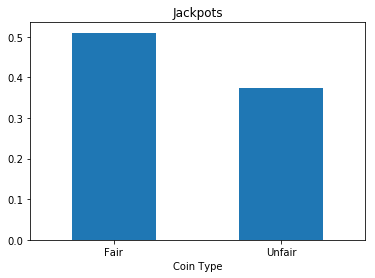

In [46]:
import pandas as pd

df = pd.DataFrame({
    'Coin Type': ['Fair', 'Unfair'],
    'Relative Jackpot Frequency': [freq_fair, freq_unfair]
})

df.plot(kind='bar', x='Coin Type', y='Relative Jackpot Frequency',
        title='Jackpots',
        legend=False, rot=0)

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [53]:
die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
die3 = Die(np.array([1, 2, 3, 4, 5, 6]))


Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [50]:
die3.change_weight(6, 5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [51]:
die2.change_weight(1, 5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [55]:
fair_die_game = Game([die1, die1, die1, die1, die1])
fair_die_game.play(10000)

Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [58]:
unfair_die_game = Game([die2, die3, die1, die1, die1])
unfair_die_game.play(10000)

Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

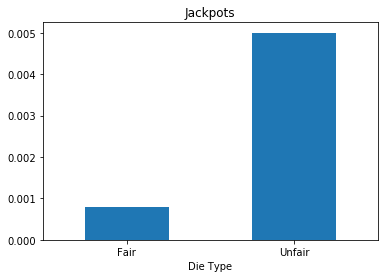

In [59]:
analyzer_fair_die = Analyzer(fair_die_game)
analyzer_unfair_die = Analyzer(unfair_die_game)

die_freq_fair = analyzer_fair_die.jackpot()/10000
die_freq_unfair = analyzer_unfair_die.jackpot()/1000

df = pd.DataFrame({
    'Die Type': ['Fair', 'Unfair'],
    'Relative Jackpot Frequency': [die_freq_fair, die_freq_unfair]
})

df.plot(kind='bar', x='Die Type', y='Relative Jackpot Frequency',
        title='Jackpots',
        legend=False, rot=0)

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [64]:
letter_freq_df = pd.read_csv('english_letters.txt', sep=' ', header=None, names=['letter', 'count'])

faces = letter_df['letter'].to_numpy()
weights = letter_df['count'].to_numpy(dtype=float)

letter_die = Die(faces=np.array(faces))


for i in range(len(faces)):
    face = faces[i]
    weight = weights[i]
    letter_die.change_weight(face, weight)

Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [67]:
letter_game = Game([letter_die, letter_die, letter_die, letter_die])
letter_game.play(1000)

Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [ ]:
#I'm sorry - I'm too tired and I gave up - seems like a fun problem though

Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).